credit card fraud detection

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
data = pd.read_csv('creditcard.csv' ,sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28


EXPLORATORY DATA ANALYSIS

In [5]:
data.isnull().values.any()

False

C:\Users\aaa\AppData\Local\Temp\ipykernel_1860\1005366056.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'], sort = True)


Text(0, 0.5, 'Frequency')

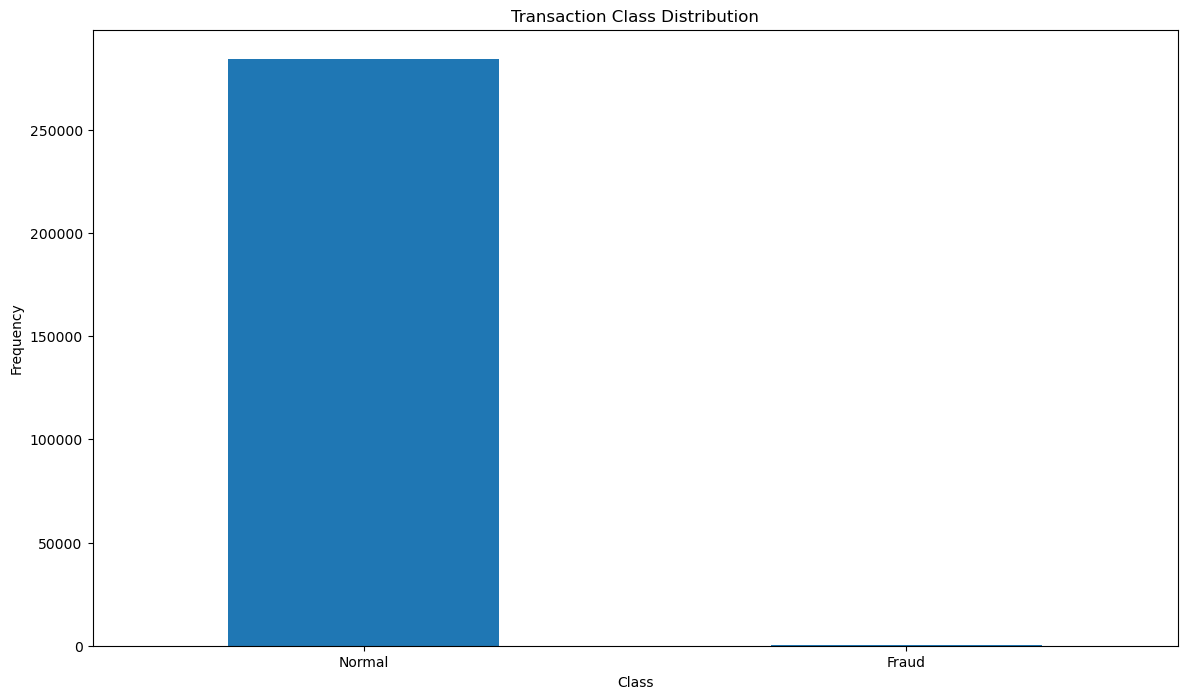

In [6]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")   

In [7]:
fraud = data[data['Class']==1]

normal = data[data['Class']==0]      

In [8]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [9]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

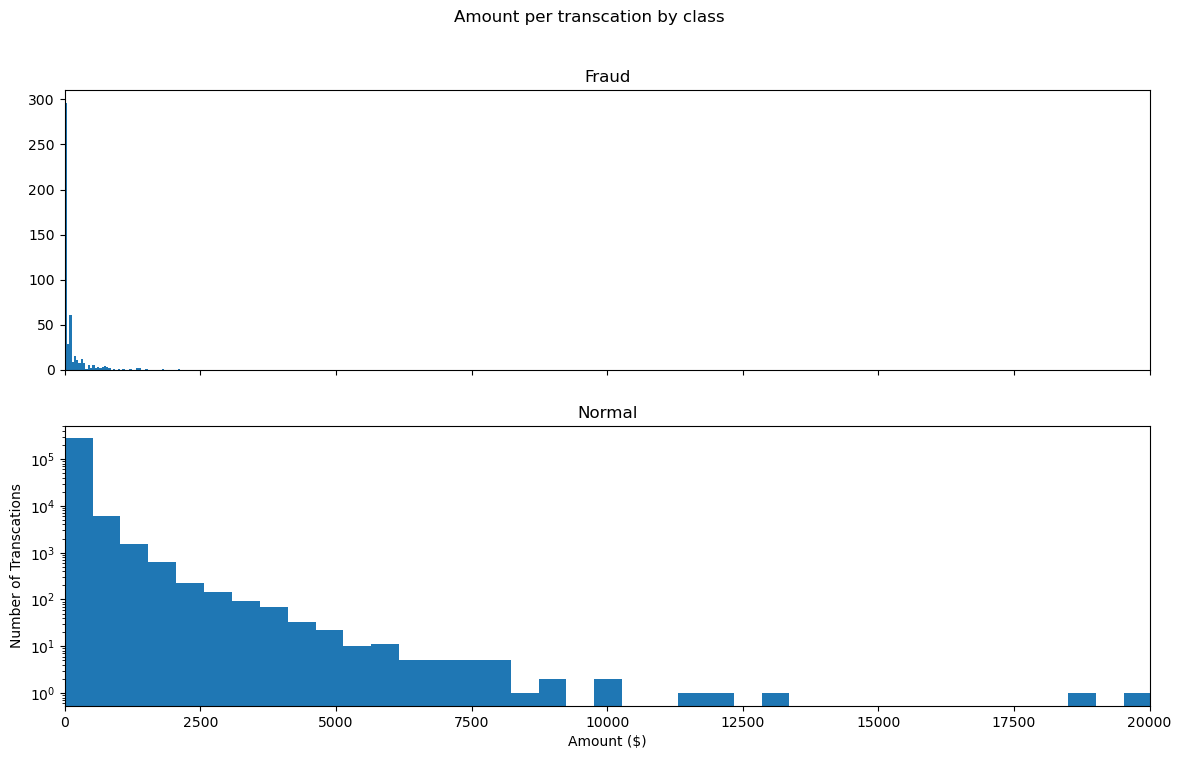

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transcation by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins= bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transcations')
plt.xlim((0,20000))
plt.yscale('log')
plt.show();

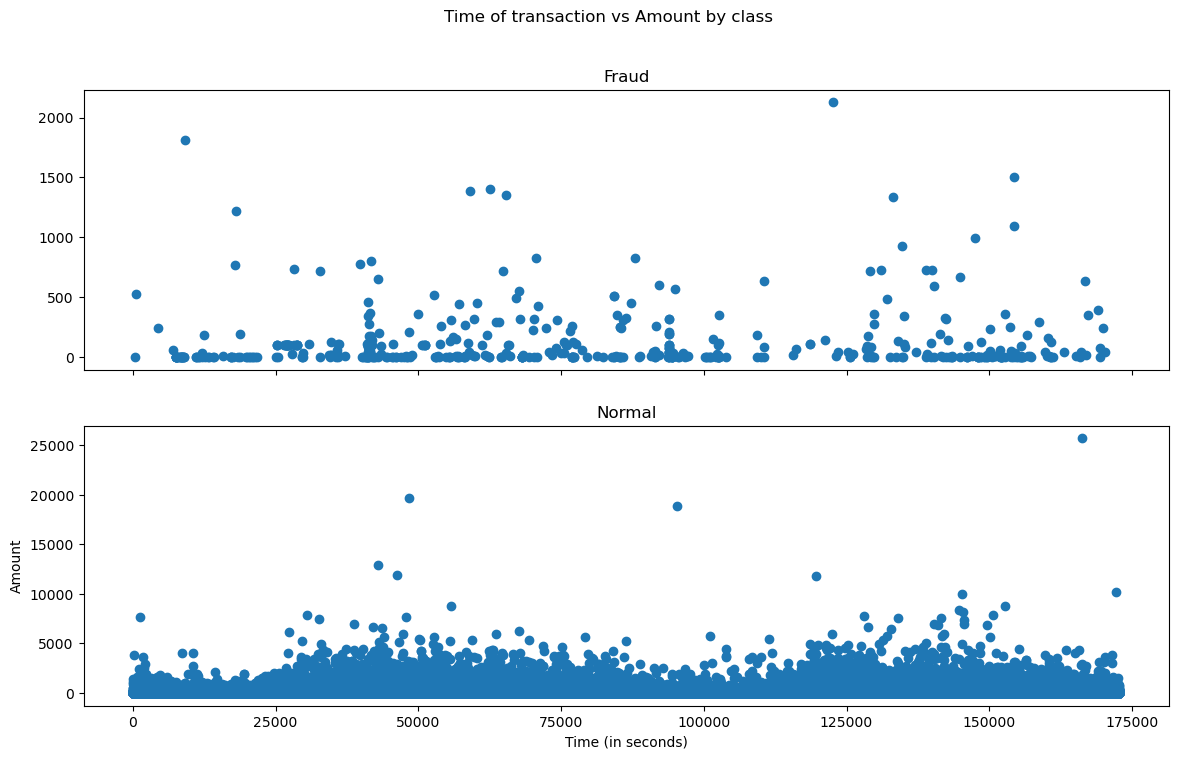

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show();

In [12]:
data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(28481, 31)

In [13]:
data.shape

(284807, 31)

In [14]:
Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [15]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


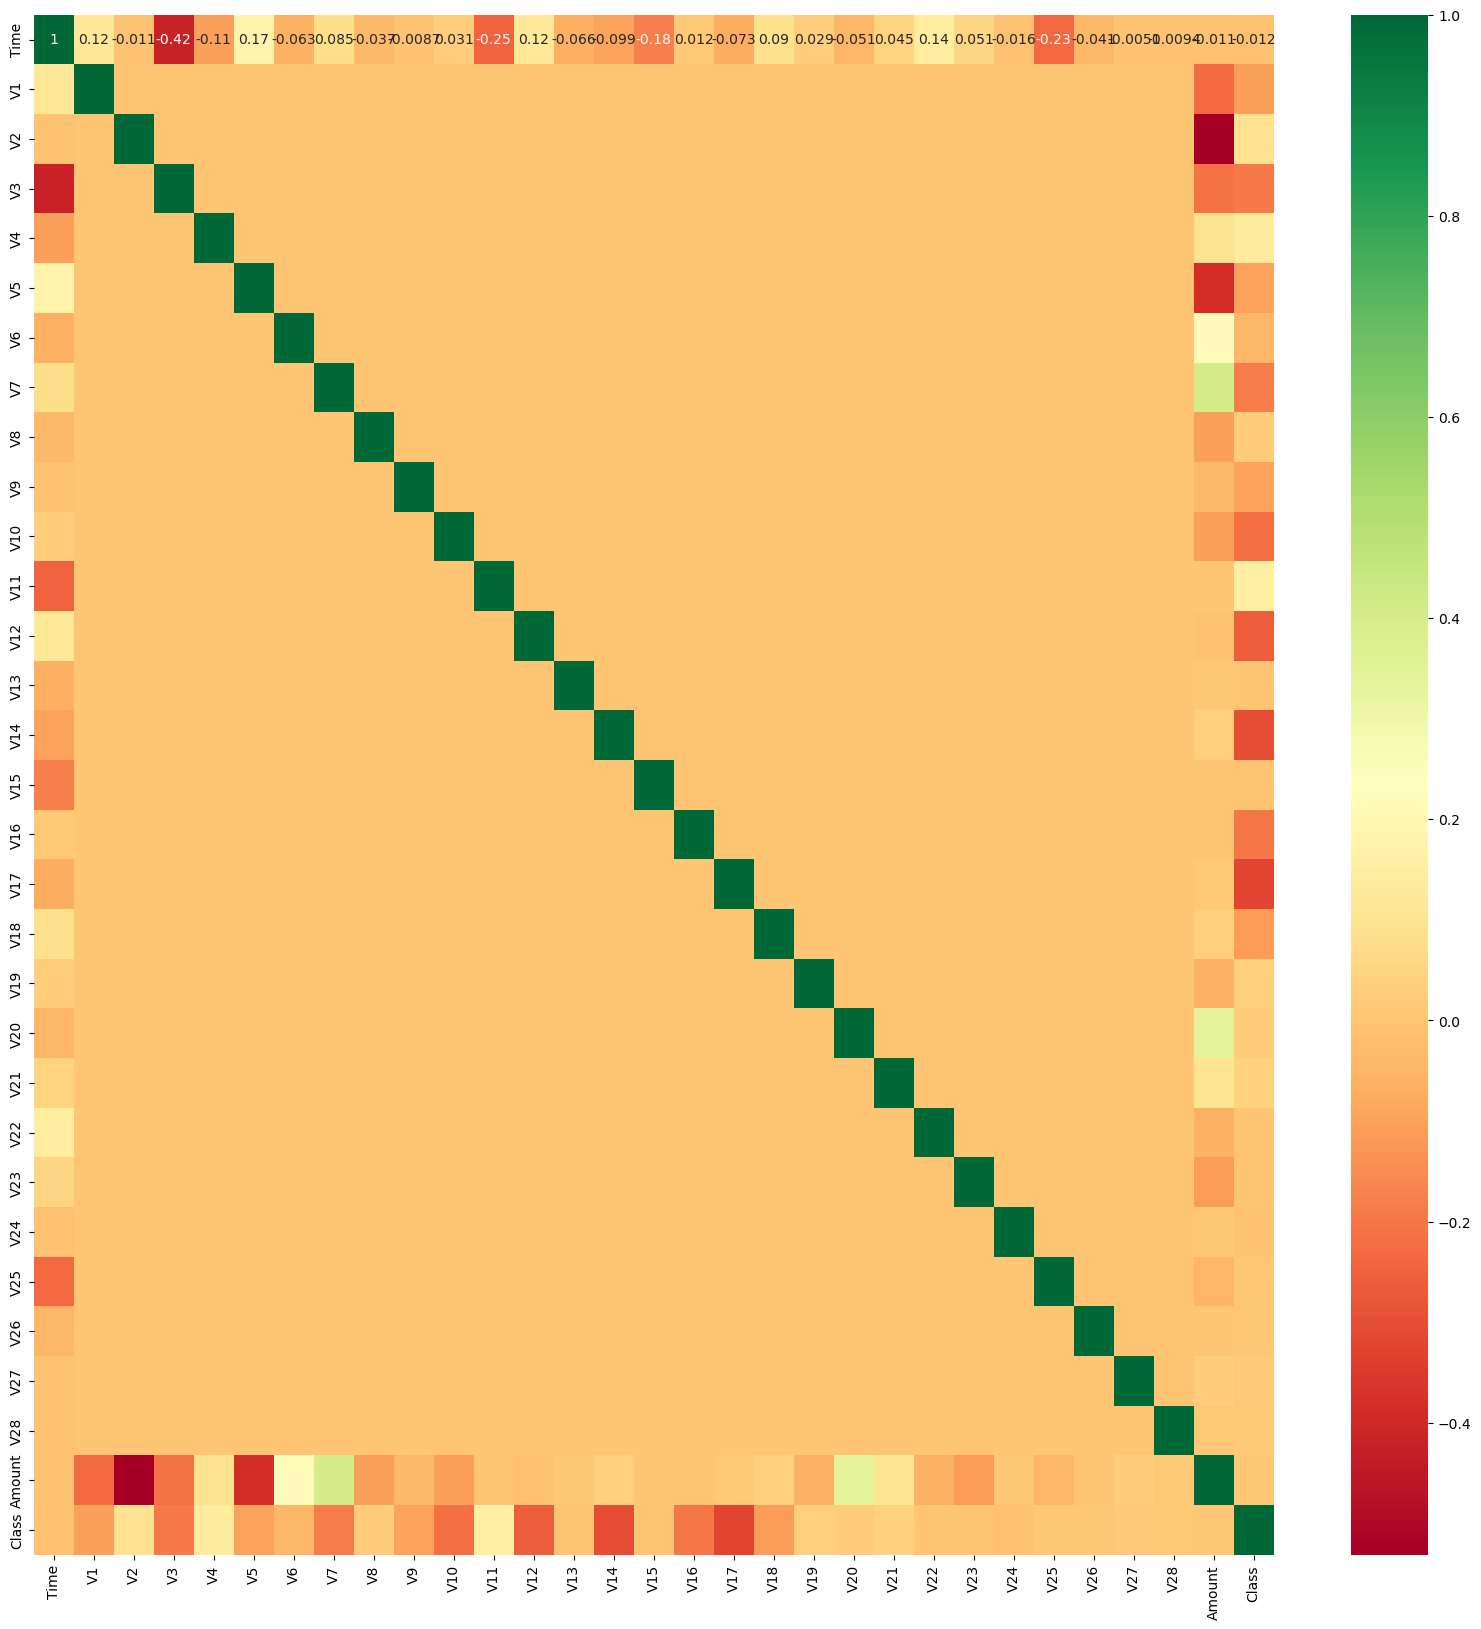

In [16]:
import seaborn as sns
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs
import numpy as np

# Create synthetic data
X, _ = make_blobs(n_samples=100, centers=1, cluster_std=0.5, random_state=42)
X = np.vstack([X, np.random.uniform(low=-6, high=6, size=(20, 2))])  # Add some outliers

# Initialize the IsolationForest model
model = IsolationForest(contamination=0.1, random_state=42)

# Fit the model
model.fit(X)

# Predict on the data
predictions = model.predict(X)

# -1 for outliers, 1 for inliers
print(predictions)

# Optionally, you can get the anomaly score for each data point
anomaly_scores = model.decision_function(X)
print(anomaly_scores)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1  1]
[ 0.26542322  0.2456944   0.23400718  0.253572    0.26855883  0.27249032
  0.15644826  0.26940911  0.2111811   0.1599431   0.19360168  0.22659128
  0.17937696  0.18895869  0.22970582  0.23599805  0.26787571  0.26305351
  0.26148117  0.20825163  0.22716917  0.14725443  0.21154993  0.2666588
  0.2717606   0.16204136  0.19043106  0.24868201  0.27119793  0.19878968
  0.26908639  0.27062442  0.25113456  0.24884539  0.25217306  0.26030874
  0.26511195  0.17565633  0.22144842  0.25617462  0.27100743  0.10186235
  0.25327586  0.27452211  0.21639765  0.27134237  0.27310946  0.26567032
  0.22144842  0.27344183  0.24457144  0.27019823  0

In [18]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_blobs
import numpy as np

# Create synthetic data
X, _ = make_blobs(n_samples=100, centers=1, cluster_std=0.5, random_state=42)
X = np.vstack([X, np.random.uniform(low=-6, high=6, size=(20, 2))])  # Add some outliers

# Initialize the LocalOutlierFactor model
model = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# Fit the model and predict on the data
predictions = model.fit_predict(X)

# -1 for outliers, 1 for inliers
print(predictions)

# Optionally, you can get the negative outlier factor for each data point
lof_scores = model.negative_outlier_factor_
print(lof_scores)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1  1 -1 -1]
[-0.97553903 -1.05905135 -1.0513423  -1.08349425 -0.94908156 -0.94664612
 -1.27565835 -0.96090372 -1.247451   -1.46873169 -1.20985243 -1.09816211
 -1.32508865 -1.18436155 -1.15664973 -1.111116   -0.96470887 -0.9953217
 -1.0014291  -1.12989453 -1.1011439  -1.50578723 -1.17710272 -0.97189383
 -0.97314579 -1.28935782 -1.24643076 -1.02472333 -0.96441952 -1.16060611
 -0.96887264 -0.96935212 -1.04770149 -1.05110061 -1.07887168 -0.99070447
 -0.98732664 -1.28615539 -1.1008252  -1.0583507  -0.97638751 -1.71975687
 -1.06963335 -0.94455729 -1.13464052 -0.96048353 -0.98139797 -0.97352155
 -1.10108011 -0.96625187 -1.05202703 -0.96984356 -1

In [19]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
import numpy as np

# Create synthetic data
X, _ = make_blobs(n_samples=100, centers=1, cluster_std=0.5, random_state=42)
X = np.vstack([X, np.random.uniform(low=-6, high=6, size=(20, 2))])  # Add some outliers

# Initialize the OneClassSVM model
model = OneClassSVM(gamma='auto', nu=0.1)

# Fit the model
model.fit(X)

# Predict on the data
predictions = model.predict(X)

# -1 for outliers, 1 for inliers
print(predictions)

[ 1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1  1 -1  1  1  1]
